# Normalizing Flows

ORCA Group Meeting February 24, 2022

# Quick Notes

- Interrupt and ask questions
- This is a jupyter notebook and so 
[managing state](https://jupytearth.org/jupyter-resources/ecosystem/managing-state.html) is 
the price of doing business, be careful if you start jumping around in the notebook
- Normalizing Flows touch a few different topics I am going to try to add references that expand on a topic by 
embeding a link in the text. For example, in this notebook we are going to use 
[Tensorflow](https://www.tensorflow.org).
- If something has more than one reference link, I'll embed the additional links using 🤔. 
For example, we will also be using [Tensorflow Probabiliy](https://www.tensorflow.org/probability/)
[🤔](https://www.tensorflow.org/probability/overview).

In [1]:
# This limits the tensorflow output log 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# These are the imports we'll need today
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, Model
tfd = tfp.distributions
tfb = tfp.bijectors

# local python file
import plot_helpers as ph

# Probabiliy Distributions

- [Probability distributions](https://en.wikipedia.org/wiki/Probability_distribution#:~:text=A%20probability%20distribution%20is%20a%20mathematical%20description%20of,vectors%2C%20a%20set%20of%20arbitrary%20non-numerical%20values%2C%20etc.) are a function that tell us how probable certain some event $x$ is.
- There are many kinds of probability distributions and covering all of the basics is a course in and of 
itself, but I will add links as we go along.
- For today, we are going to use the [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution).

# Normal Distribution

The [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution)
[🤔](https://www.youtube.com/watch?v=hgtMWR3TFnY) is a well studied and widely used
probability distribution that is parameterized by two values $\mu$ and $\sigma^2$, which are the 
mean(location) and variance(squared scale) respectively and commonly written as 
$\mathcal{N}(\mu,\sigma^2)$. The 
[probability density function](https://en.wikipedia.org/wiki/Probability_density_function) for the normal
distribution is described below:

$$f_{\mu,\sigma^2}(x)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$$
<center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/7/74/Normal_Distribution_PDF.svg"/>
</center>

# Normal Distribution - In Code

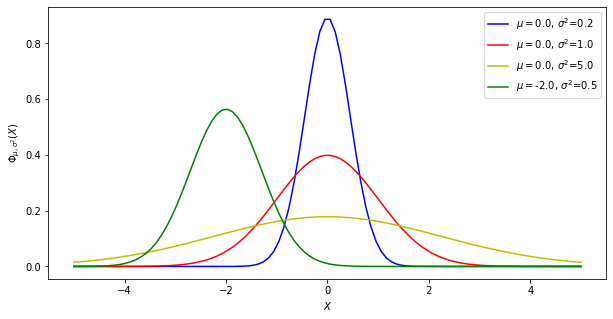

In [4]:
locations_mus = [0.0, 0.0, 0.0, -2.0]
scales_sigma2 = [0.2, 1.0, 5.0,  0.5]

xs = tf.linspace(-5.0, 5.0, num=100)
plt.figure(figsize=(10,5))
for l,s,c in zip(locations_mus, scales_sigma2, "bryg"):
    # The parameterized Normal distribution
    n=tfd.Normal(loc=l, scale=tf.math.sqrt(s))
    
    plt.plot(xs, n.prob(xs), c=c, label=f"$\mu=${l}, $\sigma^2$={s}")
plt.xlabel("$X$");plt.ylabel("$\Phi_{\mu,\sigma^2}(X)$");plt.legend();plt.show()

# Normal Distribution - In Code

Some x: <class 'numpy.ndarray'>
Relative likelihood of x: [0.30901941657066345, 0.31757164001464844]


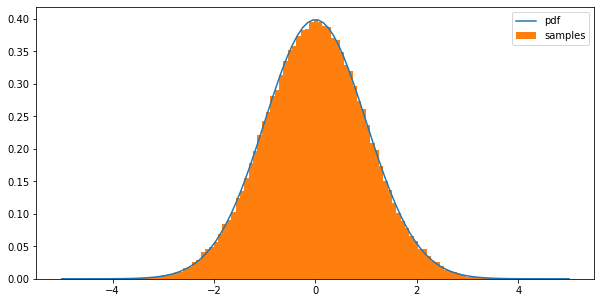

In [2]:
import numpy as np

normal = tfd.Normal(loc=0, scale=1)
samples = normal.sample(100000)
some_samples = samples[:2].numpy()
print("Some x:", type(some_samples))
print("Relative likelihood of x:", normal.prob(some_samples).numpy().tolist())
xs = tf.linspace(-5.0, 5.0, num=100)
ph.hist_with_pdf(samples, normal)

# 2D - Mutivariate Normal Distribution

So far have seen the Normal distribution in one dimension but it can be 
[multidimensional](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) as well,
where $\mu$ is now a vector $\mathbf{\mu} \in \mathcal{R}^d$ and $\sigma$ becomes the
[covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) $\mathbf{\Sigma}$ 
and the notation for the distribution becomes 
$\mathcal{N}(\mathbf{\mu},\mathbf{\Sigma})$

<center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8e/MultivariateNormal.png/793px-MultivariateNormal.png"/>
<cemter>

# 2D - Mutivariate Normal Distribution - In Code

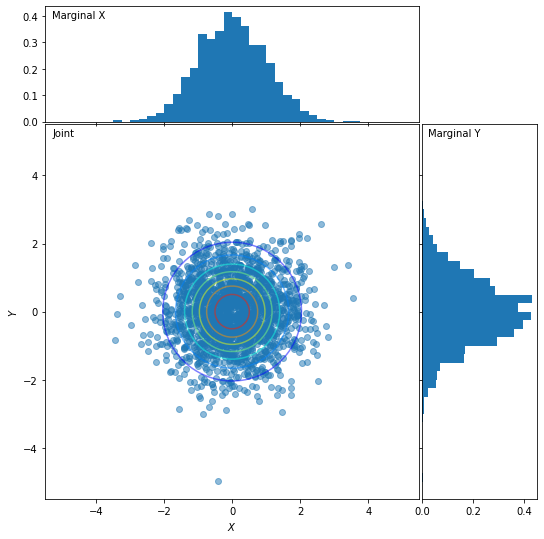

In [20]:
from importlib import reload
reload(ph)

normal_2d = tfd.MultivariateNormalDiag(loc=[0,0], scale_diag=[1, 1])
samples = normal_2d.sample(2000).numpy()
ph.hist2d_marginals(normal_2d, samples[:,0], samples[:,1])

# Why Is This Important?

- If we find that our 
[data is normally distributed](https://www.statology.org/example-of-normal-distribution/), 
that is distributed like Normal Distribution, then we use the normal distribution to 
describe our data and even draw new samples!
- But what if our data is not normally distributed? ...then 

<center><img src="https://gifimage.net/wp-content/uploads/2017/07/game-over-gif-26.gif"/></center>

# Not Quite! But first we need a tool.

- We can use the change of variables formula applied to the probablily distributions
- Suppose we have a random variable $X \in \mathbb{R}^d$ and an 
[invertible](https://en.wikipedia.org/wiki/Inverse_function) differentiable
transformation $f: \mathbb{R}^d \mapsto \mathbb{R}^d$ that when applied to $X$ 
produces a new random variable $Z$

We can calcuate the probability density function of $\mathbf{Z}$ using the 
[change of variables](https://en.wikipedia.org/wiki/Probability_density_function#Vector_to_vector)
[🤔](https://online.stat.psu.edu/stat414/lesson/23/23.1) formula:

$$
  p_\mathbf{X}(\mathbf{x}) = 
  p_\mathbf{Z}(f(\mathbf{x}))\left\vert\det Df(\mathbf{x})\right\vert
$$

Where $\det Df(\mathbf{x})$ is the [determinant of the Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant#Jacobian_determinant)[🤔](https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/jacobian/v/the-jacobian-determinant) of $f(\mathbf{x})$. We can now relate some distribution of values $X$ to some distribution $Z$ and back.

# TensorFlow Probability Can Handle This 

Let's try multiplying Our normal distribution by $\mathbf{Z} = f(\mathbf{X}) = 2\mathbf{X}$ 

In tensorflow the function used to transform probability distributions is called a *bijector*.
If you use bijectors tensorflow can automatically calculate the densities of the new 
distribution. To apply a bijector to a probability distribution use a tensorflow class called 
TransformedDistribution

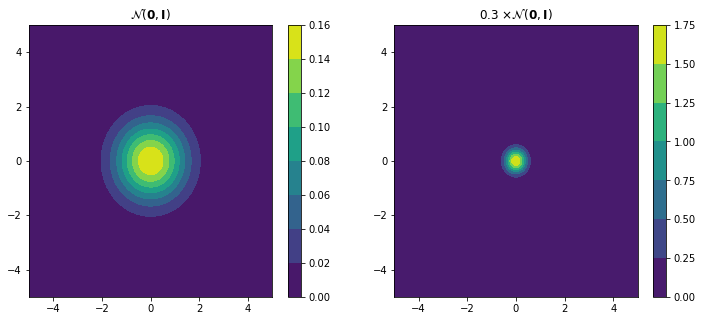

In [23]:
normal_2d = tfd.MultivariateNormalDiag(loc=[0,0], scale_diag=[1,1])
scale = 0.3
t_normal_2d = tfd.TransformedDistribution(
    distribution = normal_2d,
    bijector = tfb.Scale(scale=scale) # f(x) is also called a bijector tfb = tensorflow_probability.bijectors
)

# setup a grid of 2d values to get the relative likelihood values for
xs, ys = np.meshgrid(np.linspace(-5, 5, num=100), np.linspace(-5, 5, num=100))
vals = np.array([[y, x] for y, x in zip(ys.flatten(), xs.flatten())], dtype=np.float32)

# get the 2d contours, like the 1d curved lines previously
zs = normal_2d.prob(vals).numpy().reshape([100, 100])
t_zs = t_normal_2d.prob(vals).numpy().reshape([100, 100])

# plot!
f, axes = plt.subplots(figsize=(12,5), ncols=2)
cs = axes[0].contourf(xs, ys, zs)
axes[0].set_title("$\mathcal{N}(\mathbf{0}, \mathbf{I})$")
plt.colorbar(cs, ax=axes[0])
cs = axes[1].contourf(xs, ys, t_zs)
axes[1].set_title(str(scale) + r" $\times \mathcal{N}(\mathbf{0}, \mathbf{I})$")
plt.colorbar(cs, ax=axes[1])

# Normalizing Flow Time!

In Normalizing Flows we learn the transformation $f(\mathbf{x})$
that transforms our data distribution $p_\mathbf{X}(\mathbf{x})$ 
into our target distribution $p_\mathbf{Z}(\mathbf{z})$

- The target distribution also called Base Measure is usually chosen to be a Normal Distribution $\mathcal{N}(\mathbf{0}, \mathbf{I})$
- $f(\mathbf{x})$ is the flow function, needs to be invertible
and differentiable

# Normalizing Flows

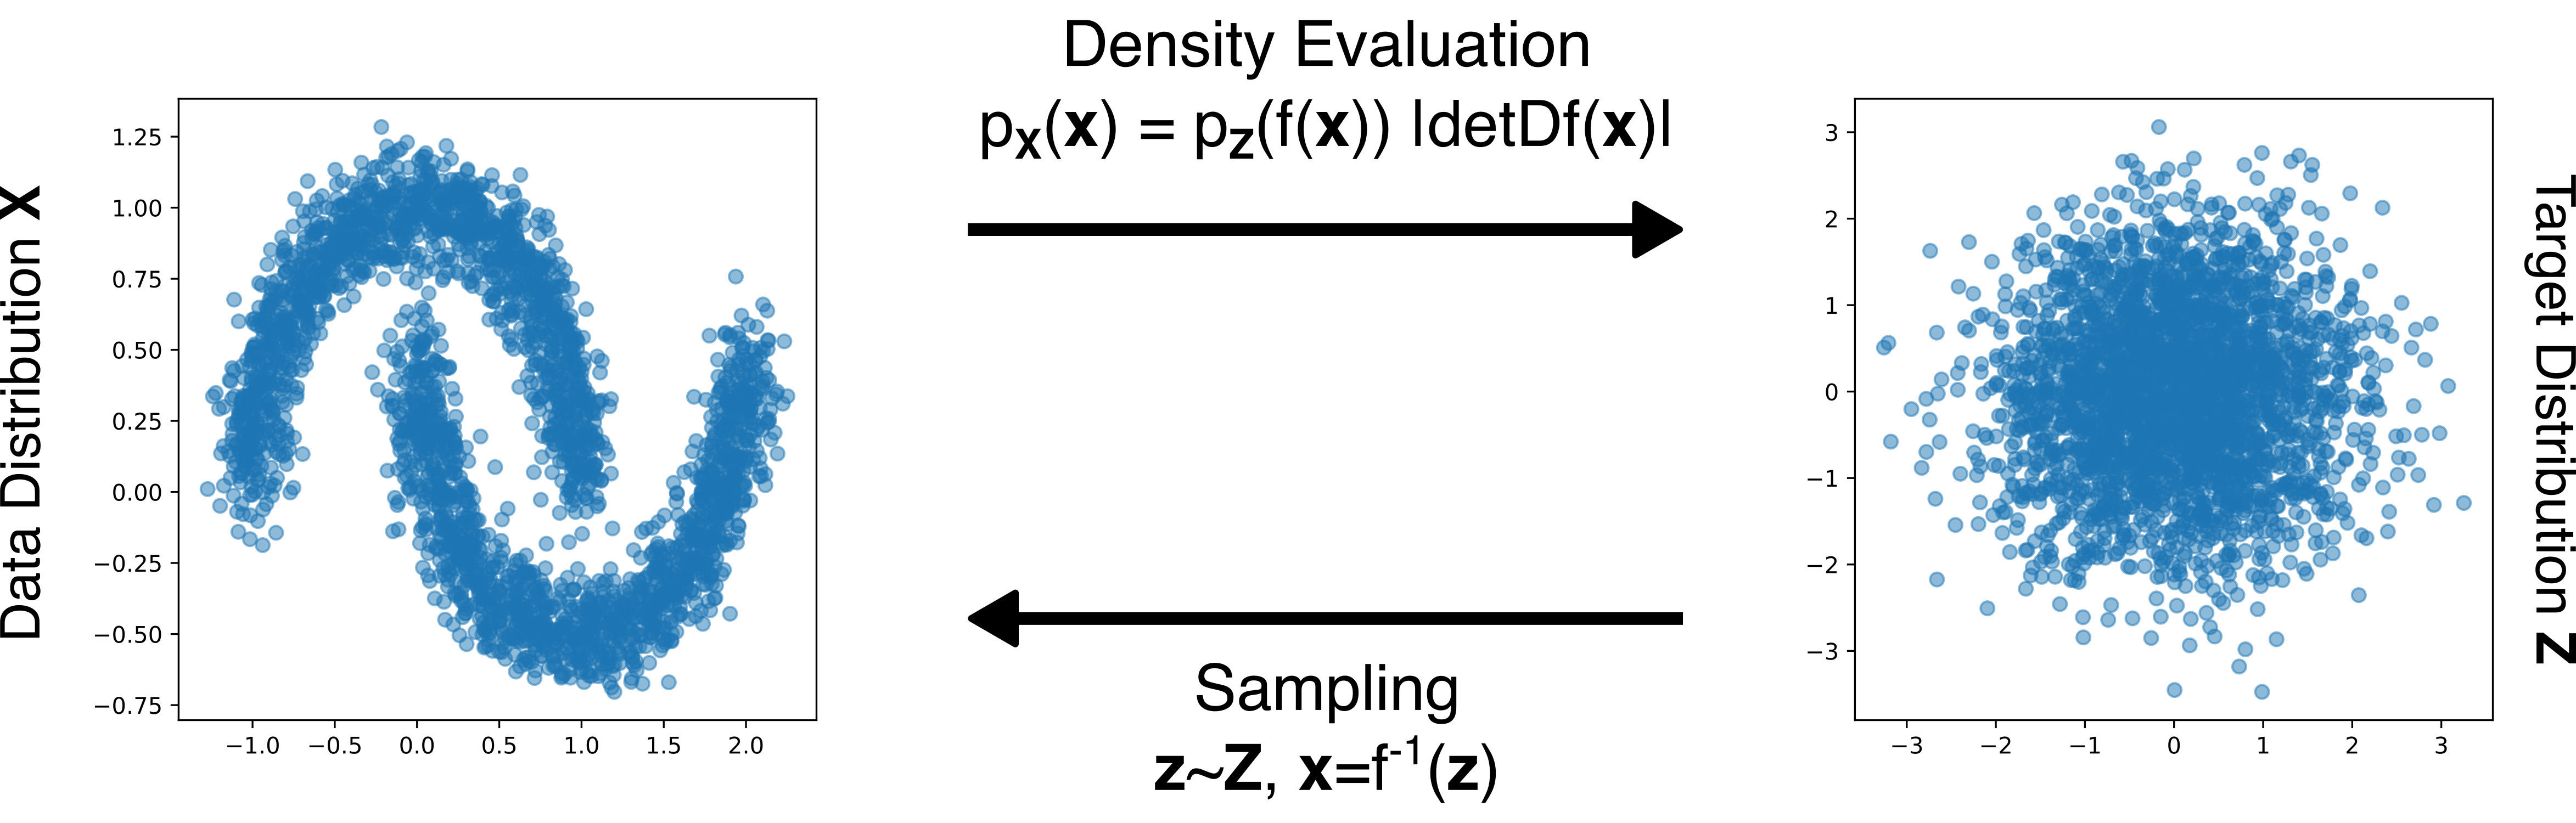

# Normalizing Flows

Similar to neural networks we can build complex flows through a series of flow functions:

<center><img src="comp-flow.png"/></center>

Figure Credit: [Marcus Brubaker](https://mbrubake.github.io/cvpr2021-nf_in_cv-tutorial/Introduction%20-%20CVPR2021.pdf)

# Normalizing Flows 

This seems pretty great what is $f$?

$f$ is called a flow function or bijection.

It generally needs to be:
- invertible
- differentiable
- have an easy to compute Jacobian determinant $|\det Df(\mathbf{x})|$



# Normalizing Flows: Coupling Flows ( [RealNVP](https://arxiv.org/abs/1605.08803))

<center><img src="coupling_forward.png"/></center>

Coupling transform: $\hat{f}(\mathbf{x}|\mathbf{s},\mathbf{t}) = \mathbf{s} \odot \mathbf{x} + \mathbf{t}$

Figure Credit: [Marcus Brubaker](https://mbrubake.github.io/cvpr2021-nf_in_cv-tutorial/Introduction%20-%20CVPR2021.pdf)

# Normalizing Flows: Coupling Flows ( [RealNVP](https://arxiv.org/abs/1605.08803))

<center><img src="coupling_inverse.png"/></center>

Coupling transform: $\hat{f}(\mathbf{x}|\mathbf{s},\mathbf{t}) = (\mathbf{x} - \mathbf{t}) \odot \frac{1}{\mathbf{s}}$
z
Figure Credit: [Marcus Brubaker](https://mbrubake.github.io/cvpr2021-nf_in_cv-tutorial/Introduction%20-%20CVPR2021.pdf)

# Coupling Flow: Determinant of the Jacobian


<center><img src="jacobian.png"/></center>

$\Theta$ can be whatever we want, For example a neural network.

Figure Credit: [Marcus Brubaker](https://mbrubake.github.io/cvpr2021-nf_in_cv-tutorial/Introduction%20-%20CVPR2021.pdf)

# Coupling Flow: Determinant of the Jacobian

How do we calculate $D\hat{f}(\mathbf{x}^B|\theta(\mathbf{x}^A))$?

Remember in our case we chose a simple function for a reason:

$\hat{f}(\mathbf{x}|\mathbf{s},\mathbf{t}) = \mathbf{s} \odot \mathbf{x} + \mathbf{t}$

So in our case the the determinant is going to be product of all of the
elements of the scaling vector: $\prod_i\mathbf{s}_i$.

# Let's Make A Coupling Flow Bijector In Tensorflow
To make something that Tensorflow can use, we need to follow some rules:
- Subclass `tfb.Bijector`
- implement the methods: `_forward`, `_inverse`, `_inverse_log_det_jacobian`, `_forward_log_det_jacobian`

(time to leave slides)

In [25]:
class CouplingFlow(tfb.Bijector):
    def __init__(self, coupling_network, validate_args=False, name='coupling_flow'):
        super(CouplingFlow, self).__init__(
            validate_args=validate_args,
            forward_min_event_ndims=1, # this means the data should always be two dimensions [batch, x]
            name=name
        )
        self.coupling_network = coupling_network
        
    def _foward(self, x):
        # x has the shape [batch_size, d], should be even
        x_a, x_b = tf.split(x, 2, axis=-1) # split x in two even pieces
        
        # coupling transform
        log_s, t = self.coupling_network(x_a)
        s = tf.exp(log_s)
        f_hat = s * x_b + t
        
        return tf.concat([x_a, f_hat], axis=-1) # put them back together
    
    def _inverse(self, z):
        # x has the shape [batch_size, d], should be even
        z_a, z_b = tf.split(z, 2, axis=-1) # split x in two even pieces
        
        # inverse coupling transform
        log_s, t = self.coupling_network(z_a)
        s = tf.exp(log_s)
        f_hat_inv = (z_b - t) / s
        
        return tf.concat([z_a, f_hat_inv], axis=-1) # put them back together

    def _inverse_log_det_jacobian(self, z):
        z_a, _ = tf.split(z, 2, axis=-1)
        log_s, t = self.nn(z_a)
        return tf.math.reduce_prod(log_s, axis=-1)   

    def _forward_log_det_jacobian(self, x):
        x_a, _ = tf.split(x, 2, axis=-1)
        log_s, t = self.nn(x_a)
        return tf.math.reduce_prod(log_s, axis=-1)   

Note the coupling flow network doesn't care about the particular coupling network

It just needs to be a function $f: \mathbb{R}^d \mapsto \mathbb{R}^d$

So lets use a neural network. Simple neural networks are easy to build in Tensorflow

In [34]:
def build_network(d, hidden_layers):
    inputs = tf.keras.Input(shape=d)
    
    x = inputs
    for hidden_layer in hidden_layers:
        x = layers.Dense(hidden_layer)(x)
        
    log_s = layers.Dense(d, name="log_s")(x)
    t = layers.Dense(d, name="t")(x)
    
    return Model(inputs, [log_s, t], name="coupling_network")

build_network(2, [8, 8]).summary()

Model: "coupling_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 8)            24          ['input_6[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 8)            72          ['dense_10[0][0]']               
                                                                                                  
 log_s (Dense)                  (None, 2)            18          ['dense_11[0][0]']               
                                                                                   

In [66]:
b = tfb.RealNVP(
    num_masked=1,
    bijector_fn=tfb.real_nvp_default_template(
        hidden_layers=[512, 512]
    )
)
b.trainable_variables

()

In [67]:
from tensorflow.keras.layers import Layer, Dense, BatchNormalization, ReLU
from tensorflow.keras import Model


class NN(Layer):
    def __init__(self, input_shape, n_hidden=[512, 512], activation="relu", name="nn"):
        super(NN, self).__init__(name="nn")
        layer_list = []
        for i, hidden in enumerate(n_hidden):
            layer_list.append(Dense(hidden, activation=activation, name='dense_{}_1'.format(i)))
            layer_list.append(Dense(hidden, activation=activation, name='dense_{}_2'.format(i)))
        self.layer_list = layer_list
        self.log_s_layer = Dense(input_shape, activation="tanh", name='log_s')
        self.t_layer = Dense(input_shape, name='t')

    def call(self, x):
        y = x
        for layer in self.layer_list:
            y = layer(y)
        log_s = self.log_s_layer(y)
        t = self.t_layer(y)
        return log_s, t

In [88]:
class RealNVP(tfb.Bijector):
    def __init__(
        self,
        input_shape,
        n_hidden=[512, 512],
        # this bijector do vector wise quantities.
        forward_min_event_ndims=1,
        validate_args: bool = False,
        name="real_nvp",
    ):
        """
        Args:
            input_shape: 
                input_shape, 
                ex. [28, 28, 3] (image) [2] (x-y vector)
                          
        """
        super(RealNVP, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=forward_min_event_ndims, name=name
        )

        assert input_shape[-1] % 2 == 0
        self.input_shape = input_shape
        nn_layer = NN(input_shape[-1] // 2, n_hidden)
        nn_input_shape = input_shape.copy()
        nn_input_shape[-1] = input_shape[-1] // 2
        x = tf.keras.Input(nn_input_shape)
        log_s, t = nn_layer(x)
        self.nn = Model(x, [log_s, t], name="nn")

    def _forward(self, x):
        x_a, x_b = tf.split(x, 2, axis=-1)
        y_b = x_b
        log_s, t = self.nn(x_b)
        s = tf.exp(log_s)
        y_a = s * x_a + t
        y = tf.concat([y_a, y_b], axis=-1)
        return y

    def _inverse(self, y):
        y_a, y_b = tf.split(y, 2, axis=-1)
        x_b = y_b
        log_s, t = self.nn(y_b)
        s = tf.exp(log_s)
        x_a = (y_a - t) / s
        x = tf.concat([x_a, x_b], axis=-1)
        return x

    def _forward_log_det_jacobian(self, x):
        _, x_b = tf.split(x, 2, axis=-1)
        log_s, t = self.nn(x_b)
        return log_s

In [89]:
b = RealNVP(
    input_shape=[2],
)

In [94]:

print(b)

nvp = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.]),
    bijector=b
)
nvp.sample(1)

tfp.bijectors.RealNVP("real_nvp", min_event_ndims=1)
<class 'tensorflow.python.framework.ops.EagerTensor'>


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 2.2096715 , -0.44325632]], dtype=float32)>

# Normalizing Flows: Optimization

Normalizing flow are trained using [Maximum Likelihood](https://mathworld.wolfram.com/MaximumLikelihood.html#:~:text=Maximum%20likelihood%2C%20also%20called%20the%20maximum%20likelihood%20method%2C,a%20parameter%20is%20denoted.%20For%20a%20Bernoulli%20distribution%2C)

<center><img src="equation.png"/></center>

Figure Credit: [Marcus Brubaker](https://mbrubake.github.io/cvpr2021-nf_in_cv-tutorial/Introduction%20-%20CVPR2021.pdf)

# Cool Things Done With Normalizing Flows

<center><img src="image-to-image.png"/></center>

Figure Credit: [Ullrich Köthe](https://mbrubake.github.io/cvpr2021-nf_in_cv-tutorial/INNs-CVPR-June-2021.pdf)

# Cool Things Done With Normalizing Flows: Latent Interpolation


<video controls src="https://cdn.openai.com/research-covers/glow/videos/prafulla_people_loop.mp4" />

# Demo Soon!
# I'll add them to the slides and then share with everyone :)

# References/Resources

- https://www.tensorflow.org/probability/examples/FFJORD_Demo
- -----> https://www.youtube.com/watch?v=8XufsgG066A <-----
- https://www.youtube.com/watch?v=u3vVyFVU_lI
- https://gebob19.github.io/normalizing-flows/
- https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html
- https://towardsdatascience.com/introduction-to-normalizing-flows-d002af262a4b
- https://github.com/gebob19/introduction_to_normalizing_flows/blob/master/normalizing_flows.ipynb
- https://github.com/ericjang/nf-jax/blob/master/nf-tutorial-jax.ipynb
- https://mbrubake.github.io/cvpr2021-nf_in_cv-tutorial/